In [0]:
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 9.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678551 sha256=b348f83b93d81eb7c067ce90f8d398f1c81a466c30b353798dab7600c3dc6222
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
sns.set_style("darkgrid")
from surprise.model_selection import cross_validate, KFold
pd.options.display.max_rows=10000
pd.options.display.max_columns=50

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Preprocess
1. Reorganize dataframe: connet the movie id with customer id and rating id.
2. Balace ratings: In the initial data set, we have 1118186 rating 1, 2439073 rating 2, 5506583 rating 5, 6904181 rating 3, and 8085741 rating 4. We have more 345, which are the higher rating movies. In order to avoid bias and run faster for the model, we balanced the ratings and took a sample.
3. Remove movies with less than 20 reviews and customers with less than 20 reviews.

In [0]:
def preprocess(file_path):
    df = pd.read_csv(file_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
    df['Rating'] = df['Rating'].astype(float)

    df_id = df.Rating.isnull()
    df_id = df_id[df_id == True].reset_index()
    movie_np,movie_id = [],0

    for i,j in zip(df_id['index'][1:],df_id['index'][:-1]):
        movie_id += 1
        temp = np.full((1,i-j-1), movie_id)
        movie_np = np.append(movie_np, temp)

    last_record = np.full((1,len(df) - df_id.iloc[-1, 0] - 1),movie_id+1)
    movie_np = np.append(movie_np, last_record)

    data = df[df.Rating.notnull()]
    data['Movie_Id'] = movie_np.astype(int)
    data['Cust_Id'] = data['Cust_Id'].astype(int)
    return data

In [0]:
def sample_balance(data, path):
    print("Selecting samples with balanced ratings...")
    df1 = data[data['Rating']==1].sample(n=1000000)
    df2 = data[data['Rating']==2].sample(n=1000000)
    df3 = data[data['Rating']==3].sample(n=1000000)
    df4 = data[data['Rating']==4].sample(n=1000000)
    df5 = data[data['Rating']==5].sample(n=1000000)
    sample = pd.concat([df1,df2,df3,df4,df5]) 
    
    print("Removing users with less reviews...")
    cid = sample.groupby(["Cust_Id"])["Movie_Id"].agg(['count']).sort_values(by = "count", ascending=False).reset_index()
    cid["%"] = cid["count"].cumsum().apply(lambda x: x/cid["count"].sum())
    cust_list = cid['Cust_Id'].tolist()[:100000]
    sample = sample.loc[data['Cust_Id'].isin(cust_list)] 
    
    print("Removing movies with less reviews...")
    mid = sample.groupby(["Movie_Id"])["Cust_Id"].agg(['count']).sort_values(by = "count", ascending=False).reset_index()
    mid["%"] = mid["count"].cumsum().apply(lambda x: x/mid["count"].sum())
    mid_list = mid['Movie_Id'].tolist()[:4417]
    sample = sample.loc[data['Movie_Id'].isin(mid_list)] 
    print("Done") 

    print("---------")
    movie_num = len(sample.Movie_Id.unique()) 
    user_num = len(sample.Cust_Id.unique())
    print("In our data set, there is a total number of", movie_num, "movies and", user_num ,"users.")
    fig, ax = plt.subplots(figsize=(8,6))
    sample.groupby(["Rating"])["Cust_Id"].agg(['count']).sort_values(by = "count").plot.bar(ax=ax,colormap='Paired')
    print("Now, we have a balanced data set with relatively even amount of ratings in five categories.")    
    print("Plot of the distribution of Ratings from 1 to 5:")
    
    movie_info = pd.read_csv(path+'movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
    movie_info.set_index('Movie_Id', inplace = True)
    
    
    movie_groupby = sample.groupby('Movie_Id')['Rating'].agg(["count","mean"])
    movie_groupby.index = movie_groupby.index.map(int)

    user_groupby = sample.groupby('Cust_Id')['Rating'].agg(["count","mean"])
    user_groupby.index = user_groupby.index.map(int)
    pivot_table = pd.pivot_table(sample,values='Rating',index='Cust_Id',columns='Movie_Id')
    
    return sample, movie_info, movie_groupby, user_groupby, pivot_table

In [0]:
path = F"/content/gdrive/My Drive/Software Design for DS - Group/"
data = preprocess(path+"combined_data_1.txt")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
data.head(10)

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
6,893988,3.0,1
7,124105,4.0,1
8,1248029,3.0,1
9,1842128,4.0,1
10,2238063,3.0,1


Selecting samples with balanced ratings...
Removing users with less reviews...
Removing movies with less reviews...
Done
---------
In our data set, there is a total number of 4417 movies and 100000 users.
Now, we have a balanced data set with relatively even amount of ratings in five categories.
Plot of the distribution of Ratings from 1 to 5:


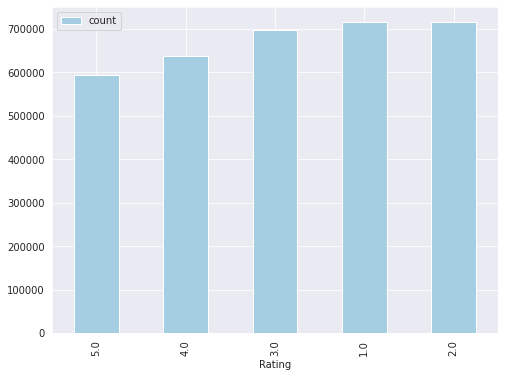

In [0]:
sample, movie_info, movie_groupby, user_groupby, pivot_table = sample_balance(data, path)

In [0]:
sample.head(5)

,Cust_Id,Rating,Movie_Id
12171243,2461667,1.0,2362
22696531,1533163,1.0,4302
16435166,941011,1.0,3168
6463702,2212890,1.0,1267
510285,1405888,1.0,148


In [0]:
movie_info.head(5)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [0]:
movie_groupby.head(5)

,count,mean
Movie_Id,,
1,77,2.766234
2,24,2.000000
3,254,3.094488
4,34,1.676471
5,179,2.687151


In [0]:
user_groupby.head(5)

,count,mean
Cust_Id,,
6,26,2.807692
7,35,3.971429
10,15,3.266667
79,49,2.836735
97,39,2.692308


In [0]:
print(len(sample))

3360824


In [0]:
factors = [50, 100, 150, 200]
epochs = [20, 30, 50]
biase = [True, False]
lr = [0.1, 0.01, 0.005]

for i in range(len(factors)):
  for j in range(len(epochs)):
    for k in range(len(biase)):
      for l in range(len(lr)):
        reader = Reader()
        data = Dataset.load_from_df(sample[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
        print(factors[i], epochs[j], biase[k], lr[l])
        svd = SVD(n_factors = factors[i], n_epochs = epochs[j], biased = biase[k], lr_all = lr[l])
        print(cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True))

50 20 True 0.1
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.0142  0.0140  0.0141  0.0141  0.0001  
MAE (testset)     0.0053  0.0052  0.0052  0.0052  0.0000  
Fit time          2.77    2.78    2.81    2.79    0.02    
Test time         0.24    1.52    0.23    0.67    0.61    
{'test_rmse': array([0.01420374, 0.01398918, 0.01413478]), 'test_mae': array([0.00531713, 0.00520527, 0.00522676]), 'fit_time': (2.7703309059143066, 2.7818031311035156, 2.8093388080596924), 'test_time': (0.23981976509094238, 1.5232579708099365, 0.2322080135345459)}
50 20 True 0.01
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.0297  0.0302  0.0294  0.0298  0.0003  
MAE (testset)     0.0135  0.0136  0.0134  0.0135  0.0001  
Fit time          2.82    2.80    2.81    2.81    0.01    
Test time         0.24    1.43    0.23    0.63    0.56    
{'tes

KeyboardInterrupt: ignored

In [0]:
class SVD_Model:
    
    def __init__(self, df_title):
        self.reader = Reader()
        self.df_title = df_title
        self.df_rating = None
        self.data = None
        self.svd = SVD(n_factors = 50, n_epochs = 30, lr_all = 0.1)
    
    def train(self, df):
        self.df_rating = df
        self.data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], self.reader)
        trainset = self.data.build_full_trainset()
        self.svd.fit(trainset)
        print("Trained Model Successfully!")
        
    def evaluate(self, n_folds = 3):
        cv = cross_validate(self.svd, self.data, measures=['RMSE', 'MAE'], cv=n_folds, verbose=True)
        print(cv)
    
    def recommend(self, user_id, n_movies = 10):
        user_movies = self.df_title.copy()
        user_movies = user_movies.reset_index()
        user_movies['Estimate_Score'] = user_movies['Movie_Id'].apply(lambda x: self.svd.predict(user_id, x).est)
        user_ratings = self.df_rating[self.df_rating.Cust_Id == user_id]
        user_movies = pd.merge(user_movies, user_ratings, how = "outer", left_on = ["Movie_Id"], right_on = ["Movie_Id"])
        user_movies = user_movies[["Year","Name","Estimate_Score"]]
        user_movies = user_movies.sort_values('Estimate_Score', ascending=False)
        return user_movies[:n_movies]
        #except:
         # print("user id not valid")
    
    def compare(self, user_id):
        user_movies = self.df_title.copy()
        user_movies = user_movies.reset_index()
        user_movies['Estimate_Score'] = user_movies['Movie_Id'].apply(lambda x: self.svd.predict(user_id, x).est)
        user_ratings = self.df_rating[self.df_rating.Cust_Id == user_id]
        user_movies = pd.merge(user_movies, user_ratings, how = "inner", left_on = ["Movie_Id"], right_on = ["Movie_Id"])
        user_movies = user_movies[["Year",	"Name", "Rating", "Estimate_Score"]]
        user_movies = user_movies.sort_values('Rating', ascending=False)
        return user_movies

In [0]:
pivot_table.head()

Movie_Id,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,...,4475,4476,4477,4478,4479,4480,4481,4482,4483,4484,4485,4486,4487,4488,4489,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499
Cust_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
svd_model = SVD_Model(movie_info)
svd_model.train(sample)

Trained Model Successfully!


In [0]:
svd_model.evaluate()

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3022  1.3018  1.3012  1.3018  0.0004  
MAE (testset)     1.0150  1.0148  1.0142  1.0146  0.0004  
Fit time          141.31  141.51  142.32  141.72  0.44    
Test time         14.05   14.54   15.17   14.59   0.46    
{'test_rmse': array([1.30222   , 1.30183103, 1.30123377]), 'test_mae': array([1.01499642, 1.01478544, 1.01415552]), 'fit_time': (141.3106985092163, 141.51251220703125, 142.32416534423828), 'test_time': (14.054834842681885, 14.537885427474976, 15.174796104431152)}


In [0]:
svd_model.evaluate()

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1413  1.1423  1.1419  1.1418  0.0004  
MAE (testset)     0.9112  0.9124  0.9120  0.9119  0.0005  
Fit time          156.91  155.57  154.15  155.54  1.13    
Test time         15.35   15.63   16.22   15.73   0.36    
{'test_rmse': array([1.14131289, 1.14231541, 1.14186694]), 'test_mae': array([0.91120658, 0.91242416, 0.91200091]), 'fit_time': (156.90621662139893, 155.5675151348114, 154.14582753181458), 'test_time': (15.354590892791748, 15.62727403640747, 16.218427658081055)}


In [0]:
recommended_movies = svd_model.recommend(1238184, 20)
recommended_movies

,Year,Name,Estimate_Score
3045,1990.0,The Simpsons: Treehouse of Horror,4.847777
2584,1994.0,Absolutely Fabulous: Series 2,4.769230
3899,2000.0,Amores Perros,4.765702
4048,1988.0,Torch Song Trilogy,4.684607
2802,1995.0,Pride and Prejudice,4.672781
2014,2002.0,Talk to Her,4.632646
3916,2004.0,Garden State,4.631292
4453,1944.0,To Have and Have Not,4.629196
2313,1956.0,Invasion of the Body Snatchers,4.557023
1263,2000.0,The Closet,4.556292


In [0]:
profile = svd_model.compare(1238184)
print("Profile of Customer "+str(1238184)+":")
profile

Profile of Customer 1238184:


,Year,Name,Rating,Estimate_Score
67,1963.0,Charade,5.0,4.518909
205,1993.0,So I Married an Axe Murderer,5.0,4.526485
209,1973.0,The Sting,5.0,3.773971
115,1992.0,Bram Stoker's Dracula,5.0,3.718002
196,1999.0,200 Cigarettes,5.0,3.007176
226,1952.0,The Quiet Man,5.0,3.991240
240,1999.0,Sleepy Hollow,5.0,3.914300
60,1994.0,The Best of Friends: Vol. 4,5.0,4.033811
224,1968.0,Yellow Submarine,5.0,3.753058
200,1988.0,Who Framed Roger Rabbit?: Special Edition,5.0,3.926044


In [0]:
class Pearson_Model:
    
    def __init__(self, df_title, df_p, df_movie_summary):
        self.df_title = df_title
        self.df_p = df_p
        self.df_movie_summary = df_movie_summary
           
    def recommend(self, movie_title, top_number, min_count = 0):
        
        print("For movie ({})".format(movie_title))
        print("- Top "+str(top_number)+" movies recommended based on Pearsons'R correlation - ")    
        i = int(self.df_title.index[self.df_title['Name'] == movie_title][0])
        target = self.df_p[i]
        similar_to_target = self.df_p.corrwith(target)
        corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
        corr_target.dropna(inplace = True)
        corr_target = corr_target.sort_values('PearsonR', ascending = False)
        corr_target.index = corr_target.index.map(int)
        corr_target = corr_target.join(self.df_title).join(self.df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
        print(corr_target[corr_target['count']>min_count][:top_number].to_string(index=False))

In [0]:
p_model = Pearson_Model(movie_info, pivot_table, movie_groupby)

In [0]:
p_model.recommend("Music of the Heart", 10)

For movie (Music of the Heart)
- Top 10 movies recommended based on Pearsons'R correlation - 


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


 PearsonR                                                   Name  count      mean
      1.0                                Where Sleeping Dogs Lie     36  1.583333
      1.0                                      Junkers Come Here     31  1.677419
      1.0                                 Live Nude Girls Unite!    142  2.042254
      1.0              Robin Hood Gang (aka Angels in the Attic)     19  1.578947
      1.0                                         Princess Daisy     39  1.717949
      1.0  The Night Before Christmas and More Christmas Stories     46  1.847826
      1.0                 National Geographic: Surviving Everest     51  1.725490
      1.0                      Dead Can Dance: Toward the Within     29  2.517241
      1.0                                          The Blue Kite     82  2.500000
      1.0                    Faith Hill: When the Lights Go Down     67  2.104478
